#Code

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Trap_simulation

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [ ]:
#@title import
import numpy as np
import torch
import time
from stopwatch import timer
import dill
from scipy.interpolate import RegularGridInterpolator
import numba
from numba import cuda

# matplotlib imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('image', cmap='Reds')
%matplotlib inline

In [ ]:
@numba.jit()
def int3d(x,y,z):
    x_ = 1-x
    y_ = 1-y
    z_ = 1-z
    out = [
           [[x_*y_*z_,x_*y_*z],
            [x*y_*z_,x*y_*z]],
           
           [[y*x_*z_,y*x_*z],
            [x*y*z_,x*y*z]]
        ]
    return np.array(out)

# @timer
@numba.jit()
def interp3d(x,y,z,m):
    c = int3d(x,y,z)
    return np.sum(m*c)

@numba.jit()
def interpolate3d(x_axis, y_axis, z_axis, x, y, z, data):
    x_min = x_axis[0]
    x_step = x_axis[1] - x_axis[0]
    x_ind = int((x-x_min)//x_step)
    x0 = ((x-x_min)%x_step)/x_step

    y_min = y_axis[0]
    y_step = y_axis[1] - y_axis[0]
    y_ind = int((y-y_min)//y_step)
    y0 = ((y-y_min)%y_step)/y_step

    z_min = z_axis[0]
    z_step = z_axis[1] - z_axis[0]
    z_ind = int((z-z_min)//z_step)
    z0 = ((z-z_min)%z_step)/z_step

    data_short = data[x_ind:x_ind+2, y_ind:y_ind+2, z_ind:z_ind+2]

    return interp3d(y0, x0, z0, data_short)

@numba.jit()
def interpolate3d_for_array(x_axis, y_axis, z_axis, x_arr, y_arr, z_arr, data): 
    N = len(x_arr) 
    out = np.zeros(N)

    for i in range(N):
        x = x_arr[i]
        y = y_arr[i]
        z = z_arr[i]

        out[i] = interpolate3d(x_axis, y_axis, z_axis, x, y, z, data)
    
    return out

# self=trap
# E = self.electrodes['rod1'].field
# o = get_field_for_array(self.axis[0],self.axis[1],self.axis[2], self.ansamble.x, self.ansamble.y, self.ansamble.z, E[0][:])
# print(o)

In [ ]:
#@title Mesh_3d
class Mesh_3d(np.ndarray):
    '''
    Mesh_3d extends np.ndarray.
    It contains the same array data, like np.ndarray, but also has got the axis attribute.
    Axis attribute is array of 3 arrays, correspondes to 3 axis, which allow to link array value to its position.
    Number of items at each of the axis subarray is the number of array data points at the corresponding direction.
    For example if the Mesh3d object has shape (l, m, n), the axis consists of 3 arrays with shapes (l,), (m,) & (n,)
    Axis attribute allow to link array value to its position.
    For example: array element with indeices [i][j][k] corresponds to the position
        x=axis[0][i], y=axis[1][j], z=axis[2][k]
    '''
    def __new__(subtype, shape=0, dtype=float, buffer=None, offset=0, strides=None, order=None, axis=None):
    	# TODO initialize with zeros
        # TODO initialize with input array + axis
        if axis is None:
            raise TypeError("Required argument 'axis' not found")
        if type(axis) != np.ndarray:
            raise TypeError("axis: expected np.ndarray, but got '{}'".format(type(axis)))
        if axis.shape[0] != 3:
            raise ValueError("axis: expected to have shape (3, x), but got '{}'".format(axis.shape))
        shape = (len(axis[0]), len(axis[1]), len(axis[2]))
        obj = super(Mesh_3d, subtype).__new__(subtype, shape, dtype,
                                                buffer, offset, strides,
                                                order)
        obj.axis = axis
        return obj

    def __array_finalize__(self, obj):
        # TODO initialize with zeros
        if obj is None: return
        self.info = getattr(obj, 'info', None)
           
    def zeroing(self):
        self[:] = np.zeros_like(self[:])
        return None

    def set_data(self, data):
        self[:] = data[:]
        return None
        
    def get_section(self, plane, coordinate):
        planes = {'x':0, 'y':1, 'z':2}
        i = planes[plane]
        ax = self.axis[i]
        
        index = (np.abs(ax - coordinate)).argmin() # index of ax[] element nearest to the desired coordinate
        
        full_slice = slice(None,None)
        slice_var = [full_slice, full_slice, full_slice]
        slice_var[i] = index
        slice_var = tuple(slice_var)    

        out = self[slice_var]
        # out = out.transpose() 
        
        return out
    
    # @timer
    def get_nearest_point_value(self, x, y, z):
        # x_ind = (np.abs(self.axis[0] - x)).argmin() # index of ax[] element nearest to the desired coordinate
        # y_ind = (np.abs(self.axis[1] - y)).argmin()
        # z_ind = (np.abs(self.axis[2] - z)).argmin()
        # start = time.time()
        # bias = self[0,0,0]

        x_min = self.axis[0][0]
        x_step = self.axis[0][1] - self.axis[0][0]
        x_ind = int((x-x_min)//x_step)
        x0 = ((x-x_min)%x_step)/x_step

        y_min = self.axis[1][0]
        y_step = self.axis[1][1] - self.axis[1][0]
        y_ind = int((y-y_min)//y_step)
        y0 = ((y-y_min)%y_step)/y_step

        z_min = self.axis[2][0]
        z_step = self.axis[2][1] - self.axis[2][0]
        z_ind = int((z-z_min)//z_step)
        z0 = ((z-z_min)%z_step)/z_step

        data_short = self[x_ind:x_ind+2, y_ind:y_ind+2, z_ind:z_ind+2]

        return interp3d(y0, x0, z0, data_short)
    
    @timer
    def get_nearest_point_value2(self, x, y, z):
        # print(x, y, z)
        # print(np.min(self.axis[0]), np.min(self.axis[1]), np.min(self.axis[2]))
        # print(np.max(self.axis[0]), np.max(self.axis[1]), np.max(self.axis[2]))
        my_interpolating_function = RegularGridInterpolator((self.axis[0], self.axis[1], self.axis[2]), self[:], method='linear')
        out = my_interpolating_function(np.array([x, y, z]))[0]
        return out
    
    def interpolate_point_vale(self):
        # TODO
        pass
    
    def plot_slice(self, axis, coordinate):
        # TODO
        pass

In [ ]:
#@title Geometry
class Geometry(Mesh_3d): 
    def create_uber_ring_3d(self, r0, thickness, x0=0, y0=0, z0=0):
        x, y, z = self.axis
        xx, yy, zz = np.meshgrid(x,y,z, sparse=True, indexing='ij')
        
        xx -= x0 # shifting the origin
        yy -= y0
        zz -= z0
        
        r = np.sqrt(xx**2 + yy**2)
        r_outter = r0
        r_inner = r_outter-thickness
        tube = (r <= r_outter) * (r >= r_inner)

        b1 = xx>(0-thickness/2)
        b2 = xx<(0+thickness/2)
        b3 = yy>r_outter-thickness/2
        tail = b1*b2*b3

        z1 = zz < 0+thickness/2
        z2 = zz > 0-thickness/2
        z = z1*z2

        self[:] = 1.0*(tube + tail)*z     
        return None
    
    def create_cylinder(self, r0, x0=0, y0=0, z_start=0, z_len=0):
        x, y, z = self.axis
        xx, yy, zz = np.meshgrid(x,y,z, sparse=True, indexing='ij')
        
        xx -= x0 # shifting the origin
        yy -= y0
        # zz -= z0
        
        r = np.sqrt(xx**2 + yy**2)
        cyl = r<r0
        
        z_end = z_start + z_len
        z = (zz > z_start) * (zz < z_end)
        out = 1.0 * cyl *z

        self[:] = out
        return None

    def create_diaphragm(self, r_out, r_hole, thickness, z0=0 ):
        x, y, z = self.axis
        xx, yy, zz = np.meshgrid(x,y,z, sparse=True, indexing='ij')
        
        zz -= z0
        
        r = np.sqrt(xx**2 + yy**2)
        aperture = (r <= r_out) * (r >= r_hole)

        z1 = zz < 0+thickness/2
        z2 = zz > 0-thickness/2
        z = z1*z2

        self[:] = 1.0*aperture*z     
        return None


    def create_cap(self):
        x, y, z = self.axis
        xx, yy, zz = np.meshgrid(x,y,z, sparse=True, indexing='ij')
        
        c = np.zeros_like(zz)

        c[0][0][0] = 1
        c[0][0][-1] = -1

        out = 1.0 * c * np.ones_like(xx) * np.ones_like(yy)

        self[:] = out
        return None


In [ ]:
#@title Electrode
class Electrode():
    def __init__(self, name, axis):
        self.name = name
        self.axis = axis
        self.geometry = Geometry(axis=axis)
        self.potential = Mesh_3d(axis=axis)
        self.field = []
        # self.interpolate_field_x = None
        # self.interpolate_field_y = None
        # self.interpolate_field_z = None
        self.time_dependence = lambda x: 1

    def set_time_dependence(self, f):
        self.time_dependence = f
        
    def calc_phi(self, mask_all=None, maxiter=int(1e6), rtol=1e-6, cuda=None):
        # TODO get rid of shitcode
        '''
        Function used to calculate potential of a givven electrode

        Parameters:
                self
                maxiter - int, maximum number of iterations to perform
                rtol - float, relative tolerance for convergence
                cuda - bool, if cuda computation mode is active

        Returns:
                potential object
        '''
        start = time.time()
        if cuda is None:
            cuda = torch.cuda.is_available()

        s2 = 1/np.sqrt(2)
        s3 = 1/np.sqrt(3)
        # kernel = np.array([[[s3,s2,s3],[s2,1,s2],[s3,s2,s3]],[[s2,1,s2],[1,0,1],[s2,1,s2]],[[s3,s2,s3],[s2,1,s2],[s3,s2,s3]]])
        kernel = np.array([[[0,0,0],[0,1,0],[0,0,0]],[[0,1,0],[1,0,1],[0,1,0]],[[0,0,0],[0,1,0],[0,0,0]]])
        kernel = kernel/np.sum(kernel)
        kernel = torch.from_numpy(kernel)
        kernel.unsqueeze_(0) #just because weight should have at least three dimensions
        kernel.unsqueeze_(0)
        if cuda:
            kernel = kernel.cuda()
        conv = torch.nn.Conv3d(1, 1, (3,3), stride=1,  bias=False, padding_mode='zeros', padding=1)
        conv.weight.data = kernel

        input1 = torch.from_numpy(self.geometry)
        input1.unsqueeze_(0)
        input1.unsqueeze_(0)
        # input1 = input1.float()
        
        if cuda:
            input1 = input1.cuda()
        phi = torch.zeros_like(input1)
        phi.copy_(input1)
        if cuda:
            phi = phi.cuda()
        mask_all = torch.tensor(mask_all)
        mask_all.unsqueeze_(0)
        mask_all.unsqueeze_(0)
        mask = phi != 0

        output = torch.zeros_like(input1)
        
        ite = 0  # iteration index
        diff = rtol + 0.1  # initial difference
        diffs = []
        while diff>rtol and ite<maxiter:
            output = conv(input1)
            output.detach_()
            output[mask_all] = 0
            output[mask] = phi[mask]
            diff = torch.sum(torch.abs(output-input1))/torch.sum(torch.abs(output))
            input1 = output
            input1.detach_()
            # torch.cuda.empty_cache()
            diffs.append(diff)
            ite += 1
            # mem_test()
        print("Electrode '{}' simulated".format(self.name))
        print("CUDA is {}".format(cuda))
        print('Simulation took {:.2e} sec'.format(time.time() - start))
        print('{} iterations made. Final relative tolerance is {:.2e}'.format(ite, diff))
        if cuda:
            out = input1.cpu().data.numpy()[0][0]
        else:
            out = input1.cpu().data.numpy()[0][0]
            # torch.cuda.empty_cache()
        self.potential[:] = out
        return diffs

    def calc_field(self):
        step_x = self.axis[0][1] - self.axis[0][0]
        E = np.gradient(self.potential)
        Ex = Mesh_3d(axis=self.axis)
        Ex.set_data(-1*E[0]/step_x)

        step_y = self.axis[1][1] - self.axis[1][0]
        Ey = Mesh_3d(axis=self.axis)
        Ey.set_data(-1*E[1]/step_y)

        step_z = self.axis[2][1] - self.axis[2][0]
        Ez = Mesh_3d(axis=self.axis)
        Ez.set_data(-1*E[2]/step_z)

        self.field = [Ex, Ey, Ez]

        self.interpolate_field_x = RegularGridInterpolator((self.axis[0], self.axis[1], self.axis[2]), Ex, method='linear')
        self.interpolate_field_y = RegularGridInterpolator((self.axis[0], self.axis[1], self.axis[2]), Ey, method='linear')
        self.interpolate_field_z = RegularGridInterpolator((self.axis[0], self.axis[1], self.axis[2]), Ez, method='linear')
        return None

    def get_potential_at_time(self, t=0):
        return self.time_dependence(t) * self.potential

    def get_field_at_time(self, t=0):
        Ex, Ey, Ez = self.field
        c = self.time_dependence(t)
        return [c*Ex, c*Ey, c*Ez]

In [ ]:
#@title Ansamble
class Ansamble():
    def __init__(self, device):
        self.device = device
        self.mass = 232*1.6e-27 # kg
        self.charge = 3*1.6e-19 # Coulomb
        self.N = 0
        self.ion_id = torch.tensor([], device=self.device, dtype=int)
        self.x = torch.tensor([], device=self.device, dtype=torch.float64)
        self.y = torch.tensor([], device=self.device, dtype=torch.float64)
        self.z = torch.tensor([], device=self.device, dtype=torch.float64)
        self.vx = torch.tensor([], device=self.device, dtype=torch.float64)
        self.vy = torch.tensor([], device=self.device, dtype=torch.float64)
        self.vz = torch.tensor([], device=self.device, dtype=torch.float64)
        self.trajectory = {}
  
    def add_ion(self, r, v):
        x, y, z = r
        vx, vy, vz = v
        self.x = torch.cat((self.x, torch.tensor([x], dtype=torch.float64, device=self.device)))
        self.y = torch.cat((self.y, torch.tensor([y], dtype=torch.float64, device=self.device)))
        self.z = torch.cat((self.z, torch.tensor([z], dtype=torch.float64, device=self.device)))
        self.vx = torch.cat((self.vx, torch.tensor([vx], dtype=torch.float64, device=self.device)))
        self.vy = torch.cat((self.vy, torch.tensor([vy], dtype=torch.float64, device=self.device)))
        self.vz = torch.cat((self.vz, torch.tensor([vz], dtype=torch.float64, device=self.device)))

        if self.N != 0:
            name = int(self.ion_id[-1]+1)
        else:
            name = 0
        self.ion_id = torch.cat((self.ion_id, torch.tensor([name], device=self.device)))
        self.trajectory[name] = []
        self.N += 1

    def remove_ion(self, ion_id, t):
        try:
            i = int(torch.nonzero(self.ion_id == ion_id)[0][0])
        except IndexError:
            print('You are trying to remove ion with invalid ion_id. No such ion founded. Removing aborted')
            return None
        ion_name = self.ion_id[i].cpu().numpy()

        def torch_remove(t, i):
            return torch.cat((t[:i],t[i+1:]))

        self.N -= 1
        self.x = torch_remove(self.x, i)
        self.y = torch_remove(self.y, i)
        self.z = torch_remove(self.z, i)
        self.vx = torch_remove(self.vx, i)
        self.vy = torch_remove(self.vy, i)
        self.vz = torch_remove(self.vz, i)
        self.ion_id = torch_remove(self.ion_id, i)

        print('Ion #{}\tis removed from computations. {}\tions left. Current time: {:.2e} sec'.format(ion_name, self.N, t))

    # @timer
    def move(self, a, dt, t, dissipate=True, gamma=None, log=False):
        start = time.time()
        ax = torch.tensor(a[0], device=self.device, dtype=torch.float64)
        ay = torch.tensor(a[1], device=self.device, dtype=torch.float64)
        az = torch.tensor(a[2], device=self.device, dtype=torch.float64)

        self.vx = self.vx + ax*dt
        self.vy = self.vy + ay*dt
        self.vz = self.vz + az*dt

        print('Move main: {:.2e}'.format(time.time() - start))
        start = time.time()

        if dissipate:
            start_1 = time.time()

            if gamma == None:
                raise ValueError('Please, define gamma variable in amsamble.move function')
            gx, gy, gz = gamma
            ax_diss = gx*self.vx/self.mass
            ay_diss = gx*self.vy/self.mass
            az_diss = gx*self.vz/self.mass

            vx_diss = self.vx - ax_diss*dt
            vy_diss = self.vy - ay_diss*dt
            vz_diss = self.vz - az_diss*dt

            print('diss_1: {:.2e}'.format(time.time() - start_1))
            start_1 = time.time()

            vx_diss[abs(vx_diss) > abs(self.vx)] = 0
            vy_diss[abs(vy_diss) > abs(self.vy)] = 0
            vz_diss[abs(vz_diss) > abs(self.vz)] = 0

            print('diss_compare: {:.2e}'.format(time.time() - start_1))
            start_1 = time.time()

            self.vx = vx_diss
            self.vy = vy_diss
            self.vz = vz_diss
            print('diss_end: {:.2e}'.format(time.time() - start_1))
            start_1 = time.time()

        print('Move dissipate: {:.2e}'.format(time.time() - start))
        start = time.time()

            
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        self.z = self.z + self.vz*dt

        if log:
            for i in range(self.N):
                name = self.ion_id.cpu().numpy()[i]
                x = self.x.cpu().numpy()[i]
                y = self.y.cpu().numpy()[i]
                z = self.z.cpu().numpy()[i]
                vx = self.vx.cpu().numpy()[i]
                vy = self.vy.cpu().numpy()[i]
                vz = self.vz.cpu().numpy()[i]
                acx = ax.cpu().numpy()[i]
                acy = ay.cpu().numpy()[i]
                acz = az.cpu().numpy()[i]
                self.trajectory[name].append(np.copy([t,x,y,z,vx,vy,vz,acx,acy,acz]))

        print('Move end: {:.2e}'.format(time.time() - start))
        start = time.time()
        
    def ion_source(self, N, x0, y0, z0, dx, dy, dz, dvx, dvy, dvz, distribution='gauss'):
        vx = 0
        vy = 0
        vz = 0

        if distribution == 'gauss':
            x = np.random.normal(x0, dx, N)
            y = np.random.normal(y0, dy, N)
            z = np.random.normal(z0, dz, N)
            for i in range(N):
                self.add_ion([x[i], y[i], z[i]], [vx, vy, vz])
        elif distribution == 'uniform':
            n = int(np.cbrt(N))
            x = np.linspace(x0-dx, x0+dx, n) + (np.random.rand(n)-0.5)*dx/1
            y = np.linspace(y0-dy, y0+dy, n) + (np.random.rand(n)-0.5)*dy/1
            z = np.linspace(z0-dz, z0+dz, n) + (np.random.rand(n)-0.5)*dz/1
            for i in range(n):
                for j in range(n):
                    for k in range(n):
                        p = 0.15
                        rx = (np.random.rand()-0.5)*dx*p
                        ry = (np.random.rand()-0.5)*dy*p
                        rz = (np.random.rand()-0.5)*dz*p
                        self.add_ion([x[i]+rx, y[j]+ry, z[k]+rz], [vx, vy, vz])
        else:
            raise ValueError ("Unknown 'type' argument in the 'ion_source' function")

        
        # vx = np.random.normal(0, dvx)
        # vy = np.random.normal(0, dvy)
        # vz = np.random.normal(0, dvz)
        

    # @timer
    def interaction(self, stopwatch=False):
        k = 8.9875517923e9
        q = self.charge
        # f_out = [[], [], []]
        
        start = time.time()
        xx = self.x.repeat(1,self.N).reshape([self.N,self.N])
        rx = xx - xx.T
        del xx
        yy = self.y.repeat(1,self.N).reshape([self.N,self.N])
        ry = yy - yy.T
        del yy
        zz = self.z.repeat(1,self.N).reshape([self.N,self.N])
        rz = zz - zz.T
        del zz
        if stopwatch:
            print('xx,yy,zz: {:.2e} sec'.format(time.time()-start))
            start = time.time()

        r = torch.sqrt(rx**2 + ry**2 + rz**2)
        if stopwatch:
            print('r: {:.2e} sec'.format(time.time()-start))
            start = time.time()

        f_i = 1/r**3
        if stopwatch:
            print('f_i: {:.2e} sec'.format(time.time()-start))
            start = time.time()

        f_i.fill_diagonal_(0)
        if stopwatch:
            print('f_i zeroing: {:.2e} sec'.format(time.time()-start))
            start = time.time()

        c = k*q*q
        f_out_x = c*torch.sum(rx*f_i, dim=0)
        f_out_y = c*torch.sum(ry*f_i, dim=0)
        f_out_z = c*torch.sum(rz*f_i, dim=0)

        f_out = torch.stack([f_out_x, f_out_y, f_out_z])
        if stopwatch:
            print('f_out: {:.2e} sec'.format(time.time()-start))
            start = time.time()

        return f_out

    def dissipation(self, gamma=[0,0,0]):
        vz = self.vz
        Fx = -gamma[0]*self.vx
        Fy = -gamma[1]*self.vy
        Fz = -gamma[2]*self.vz
        return np.array([Fx.cpu().numpy(), Fy.cpu().numpy(), Fz.cpu().numpy()])

    def reset_trajectory(self):
        self.trajectory = {}
        for ion_name in self.ion_id:
            self.trajectory[ion_name.item()] = []

In [ ]:
#@title Trap
class Trap:
    def __init__(self):
        self.config = {}
        self.device = 'cuda'
        self.t = 0
        self.axis = ()
        self.dim = ()
        self.electrodes = {}
        self.ansamble = Ansamble(self.device)

    def define_mesh(self):
        x_min, x_max = self.config['x_lims']
        y_min, y_max = self.config['y_lims']
        z_min, z_max = self.config['z_lims']
        step = self.config['mesh_step']
        
        x = np.arange(x_min, x_max, step)
        y = np.arange(y_min, y_max, step)
        z = np.arange(z_min, z_max, step)
        self.axis = np.array([x, y, z])
        self.dim = (len(x), len(y), len(z))
        return None 
    
    def add_electrode(self, name):
        a = Electrode(name, self.axis)
        self.electrodes[name] = a
        self.__dict__[name] = a
            
    def calc_all(self, *arg, **kwarg):
        mask_all_electrodes = self.get_full_geometry() != 0
        for electrode_name in self.electrodes:
            self.electrodes[electrode_name].calc_phi(mask_all=mask_all_electrodes, *arg, **kwarg)
            self.electrodes[electrode_name].calc_field()
        return None
            
    def get_full_geometry(self, t=0):
        # TODO get rid og shit-code
        out = Geometry(axis=self.axis)
        out[:] = np.zeros_like(out) 
        for electrode_name in self.electrodes:
            c_t = self.electrodes[electrode_name].time_dependence(t)
            out[:] += c_t*self.electrodes[electrode_name].geometry[:]
        return out
    
    def get_full_phi(self, t=0):
        out = Geometry(axis=self.axis)
        out[:] = np.zeros_like(out)
        for electrode_name in self.electrodes:
            out[:] += self.electrodes[electrode_name].get_potential_at_time(t)[:]
        for electrode_name in self.electrodes:
            mask = (self.electrodes[electrode_name].geometry[:] != 0)
            out[mask] = self.electrodes[electrode_name].get_potential_at_time(t)[mask]
        return out
    
    def get_phi_at_point(self, t=0, x=None, y=None, z=None):
        phi_out = 0
        for electrode_name in self.electrodes:
            c_t = self.electrodes[electrode_name].time_dependence(t)
            try:
                phi_out += c_t*self.electrodes[electrode_name].potential.get_nearest_point_value(x, y, z)
            except ValueError:
                print('Point is out of trap area')
                return None
        return phi_out

    def get_full_field(self, t=0):
        Ex_ = Mesh_3d(axis=self.axis)
        Ex_.zeroing()
        Ey_ = Mesh_3d(axis=self.axis)
        Ey_.zeroing()
        Ez_ = Mesh_3d(axis=self.axis)
        Ez_.zeroing()
        for electrode_name in self.electrodes:
            E_ = self.electrodes[electrode_name].get_field_at_time(t) 
            start1 = time.time()
            Ex_ += E_[0] 
            Ey_ += E_[1] 
            Ez_ += E_[2]   
        return [Ex_, Ey_, Ez_]

    # @timer
    def get_fields_at_point(self, t=0):
        if len(self.ansamble.ion_id) == 0:
            print('No ions left')
            return None

        E_out = np.zeros((3,self.ansamble.N))

        x_axis = self.axis[0]
        y_axis = self.axis[1]
        z_axis = self.axis[2]

        x = self.ansamble.x.cpu().numpy()
        y = self.ansamble.y.cpu().numpy()
        z = self.ansamble.z.cpu().numpy()

        for electrode_name in self.electrodes:
            c_t = self.electrodes[electrode_name].time_dependence(t)
            E = self.electrodes[electrode_name].field

            Ex = interpolate3d_for_array(x_axis, y_axis, z_axis, x, y, z, E[0][:])
            Ey = interpolate3d_for_array(x_axis, y_axis, z_axis, x, y, z, E[1][:])
            Ez = interpolate3d_for_array(x_axis, y_axis, z_axis, x, y, z, E[2][:])

            E_electrode = c_t*np.array([Ex, Ey, Ez])
            E_out += E_electrode
        return E_out

    def get_ideal_field(self, t=0, x=None, y=None, z=None):
        if len(self.ansamble.ion_id) == 0:
            print('No ions left')
            return None
        V = self.config['V']
        U = self.config['U']
        f = self.config['freq']
        r0 = self.config['r0']
        V_ring = self.config['ring_voltage']
        d = 30e-3
        c_t = 2*(V*np.cos(2*np.pi*f*t)+U)/r0**2
        z0 = self.config['z0']
        Ex =  c_t*self.ansamble.x
        Ey = -c_t*self.ansamble.y
        Ez = -2*V_ring/d**2*(self.ansamble.z-z0)
        return np.array([Ex.cpu().numpy(),Ey.cpu().numpy(),Ez.cpu().numpy()])

    def remove_outsiders(self):
        x = self.ansamble.x
        y = self.ansamble.y
        z = self.ansamble.z

        x_min = self.axis[0][0]
        x_max = self.axis[0][-1]
        y_min = self.axis[1][0]
        y_max = self.axis[1][-1]
        z_min = self.axis[2][0]
        z_max = self.axis[2][-1]

        x_out = (x > x_max) + (x < x_min)
        y_out = (y > y_max) + (y < y_min) 
        z_out = (z > z_max) + (z < z_min)

        ions_out = torch.nonzero(x_out + y_out + z_out)
        ions_out_id = self.ansamble.ion_id[ions_out]

        for i in ions_out_id:
            self.ansamble.remove_ion(i, self.t)


    # @timer
    def simulate(self, t_max, dt, gamma=[0,0,0], min_ion_num=0, max_ion_num=np.inf, is_trap=True, is_ideal_field=False,
                 is_dissipate=True, is_interact=True, stopwatch=False, max_iter=None, log=False,
                 build_cristall=False, estimate_a2=False):
        ite = 0
        start_main = time.time()
        start_cylcle = time.time()
        
        while self.t < t_max and self.ansamble.N > min_ion_num:
            if ite % 20000 == 0:
                print('Current iteration = {}.\t{:.2e} sec simulated. Cycle took {:.2e} sec'.format(ite, self.t, time.time()-start_cylcle))
                start_cylcle = time.time()

            force = torch.zeros((3, self.ansamble.N), device=self.device)

            if is_trap:
                start = time.time()
                if is_ideal_field:
                    E  = trap.get_ideal_field(self.t)
                else:
                    E =  trap.get_fields_at_point(self.t)
                Fx, Fy, Fz = self.ansamble.charge*E
                if stopwatch:
                    print('get_field_at_point time: {:.2e} sec'.format(time.time() - start))
                force_trap = np.array([Fx,Fy,Fz], dtype=np.float64)
                force_trap = torch.from_numpy(force_trap)
                force_trap = force_trap.cuda()
                force += force_trap

            if is_interact:
                start = time.time()
                force_interaction = self.ansamble.interaction()
                force += force_interaction
                if stopwatch:
                    print('interact time: {:.2e} sec'.format(time.time() - start))

            if is_dissipate:
                pass

            acceleration = force/self.ansamble.mass
            start = time.time()
            self.ansamble.move(acceleration, dt, self.t, is_dissipate, gamma, log)
            if stopwatch:
                print('move time: {:.2e} sec'.format(time.time() - start))
            
            self.remove_outsiders()
            self.t += dt
            ite += 1

            if max_iter != None:
                if ite == max_iter:
                    break
            if estimate_a2:
                a2 = acceleration[0]**2 + acceleration[1]**2 + acceleration[2]**2
                a2_max = torch.max(a2).cpu().numpy()
                if a2_max < 1e12:
                    print('Ions is cooled. Iter# {}'.format(ite))
                    if build_cristall:
                        if self.ansamble.N < max_ion_num:
                            z0 = self.config['z0']
                            self.ansamble.add_ion((np.random.rand(3)-0.5)*2e-3+np.array([0,0,z0]),[0.0,0.0,0.0])
                            print('Ion added. {} ions inside trap.'.format(self.ansamble.N))
                        else:
                            break
                    else:
                        break
            
        print('Ions left: {}'.format(len(self.ansamble.ion_id)))
        print('Simulation time: {:.2e} sec'.format(self.t))
        print('Steps made: {}. \t Time spend: {:.2e}'.format(ite, time.time()-start_main))
   
    def reset_simulation(self):
        self.ansamble = Ansamble(self.device)

    def create_section(self,name, start, length):
        a = (self.config['r0']+self.config['r_rod'])/np.sqrt(2)
        r_rod = self.config['r_rod']
        V = self.config['V']
        U = self.config['U']
        f = self.config['freq']

        for i in [-1,1]:
            for j in [-1,1]:
                rod_name = name+'_{}{}'.format(i,j)
                self.add_electrode(rod_name)
                self.electrodes[rod_name].geometry.create_cylinder(r_rod,a*i,a*j, start, length)
                self.electrodes[rod_name].set_time_dependence(rf(V,U,f,np.pi/2*i*j))

    def build_geometry(self, geometry):
        for section in geometry['sections']:
            name = section['name']
            start = section['start']
            length = section['length']
            self.create_section(name, start, length)
        for ring in geometry['rings']:
            name = ring['name']
            r = ring['r']
            thickness = ring['thickness']
            voltage = ring['voltage']
            x,y,z = ring['position']
            self.add_electrode(name)
            self.electrodes[name].geometry.create_uber_ring_3d(r, thickness, x, y, z)
            self.electrodes[name].set_time_dependence(const_volatage(voltage))
        for diaphragm in geometry['diaphragmes']:
            name = diaphragm['name']
            r_out = diaphragm['r_out']
            r_hole = diaphragm['r_hole']
            thickness = diaphragm['thickness']
            z0 = diaphragm['z0']
            self.add_electrode(name)
            self.electrodes[name].geometry.create_diaphragm(r_out, r_hole, thickness, z0)
            self.electrodes[name].set_time_dependence(const_volatage(voltage))

    def save_to_file(self, filename):
        electrodes = []
        for electrode_name in self.electrodes:
            electrode = self.electrodes[electrode_name]
            data = {
                'name': electrode.name,
                'geometry': electrode.geometry,
                'potential': electrode.potential,
                'time_dependence': electrode.time_dependence,
            }
            electrodes.append(data)

        output = {
            'electrodes': electrodes,
            'config': self.config,
            'geometry_description': trap.geometry_description,

            'N' : trap.ansamble.N,
            'ion_id' : trap.ansamble.ion_id.cpu().numpy(),
            'x': trap.ansamble.x.cpu().numpy(),
            'y': trap.ansamble.y.cpu().numpy(),
            'z': trap.ansamble.z.cpu().numpy(),
            'vx': trap.ansamble.vx.cpu().numpy(),
            'vy': trap.ansamble.vy.cpu().numpy(),
            'vz': trap.ansamble.vz.cpu().numpy(),
            'trajectory': trap.ansamble.trajectory,
            't' : trap.t,
            'axis' : trap.axis,
            }

        f = open(filename, 'wb')
        dill.dump(output, f)
        f.close()

    def load_from_file(self, filename):
        f = open(filename, 'rb')
        data = dill.load(f)
        f.close()

        self.axis = data['axis']
        self.config = data['config']
        self.geometry_description = data['geometry_description']

        for electrode in data['electrodes']:
            name = electrode['name']
            self.add_electrode(name)
            self.electrodes[name].geometry =  electrode['geometry']
            self.electrodes[name].potential =  electrode['potential']
            self.electrodes[name].time_dependence =  electrode['time_dependence']
            self.electrodes[name].calc_field()

        self.ansamble.N = torch.tensor(data['N'], device=self.device, dtype=torch.float64)
        self.ansamble.ion_id = torch.tensor(data['ion_id'], device=self.device, dtype=torch.float64)
        self.ansamble.x = torch.tensor(data['x'], device=self.device, dtype=torch.float64)
        self.ansamble.y = torch.tensor(data['y'], device=self.device, dtype=torch.float64)
        self.ansamble.z = torch.tensor(data['z'], device=self.device, dtype=torch.float64)
        self.ansamble.vx = torch.tensor(data['vx'], device=self.device, dtype=torch.float64)
        self.ansamble.vy = torch.tensor(data['vy'], device=self.device, dtype=torch.float64)
        self.ansamble.vz = torch.tensor(data['vz'], device=self.device, dtype=torch.float64)
        self.ansamble.trajectory = data['trajectory']

        self.geometry_description = data['geometry_description']


#Setting trap properties

In [ ]:
a = 10e-3

config = {}
config['freq'] = 2.4e6 # Hz
config['U'] = 0 # Volts
config['V'] = 408 # RF Volts
config['r0'] = 3.55e-3 # m
config['r_rod'] = 4e-3 #m
config['m'] = 232*1.6e-27 # kg
config['q'] = 3*1.6e-19 # Coulomb
config['x_lims'] = [-a,a]
config['y_lims'] = [-a,a]
config['z_lims'] = [0,85e-3]
config['mesh_step'] = 0.25e-3
config['ring_voltage'] = 100

geometry = {}
geometry['param'] = {
    'kfm_len': 50e-3,
    'bb2_len': 30e-3,
    'gap': 1e-3,
}
geometry['sections'] = []
geometry['sections'].append({
    'name': 'kfm',
    'start': geometry['param']['gap'],
    'length': geometry['param']['kfm_len'],
})
geometry['sections'].append({
    'name': 'bb2',
    'start': 2*geometry['param']['gap'] + geometry['param']['kfm_len'],
    'length': geometry['param']['bb2_len']
})
geometry['rings'] = []
geometry['rings'].append({
    'name': 'ring1',
    'r': 0.33e-2,
    'thickness': 1e-3,
    'position': [0,0,11e-3],
    'voltage': config['ring_voltage'],
})
geometry['rings'].append({
    'name': 'ring2',
    'r': 0.33e-2,
    'thickness': 1e-3,
    'position': [0,0,41e-3],
    'voltage': config['ring_voltage'],
})
geometry['diaphragmes'] = []
geometry['diaphragmes'].append({
    'name': 'd4',
    'r_out': 9e-3,
    'r_hole': 1.5e-3,
    'thickness': 1e-3,
    'z0': 3*geometry['param']['gap'] + geometry['param']['kfm_len'] + geometry['param']['bb2_len'] + 1e-3/2,
    'voltage': -100,
})

config['z0'] = geometry['sections'][0]['length']/2 + geometry['param']['gap']

In [ ]:
trap.config = config
trap.geometry_description = geometry

In [ ]:
def rf(V, U, f, phase=0):
    def wrapped(t):
        return V*np.cos(2*np.pi*f*t+phase) + U
    return wrapped

def const_volatage(U0):
    def wrapped(t):
        return U0
    return wrapped

def step(U0, t0, slope):
    def wrapped(t):
        if slope == '+':
            b = True
        if slope == '-':
            b = False
        return U0*((t > t0) == b)
    return wrapped

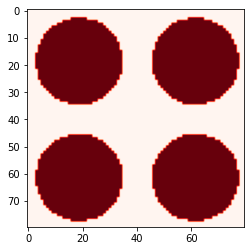

In [ ]:
d = (trap.config['r0']+trap.config['r_rod'])/np.sqrt(2)
gg = trap.get_full_geometry(0)
plt.imshow(gg.get_section('z',2e-3))
# plt.imshow(gg.get_section('x',d))
# plt.imshow(gg.get_section('x',0))

In [ ]:
# freq = 2.4e6 # Hz
# U = 0 # Volts
# V = 408 # RF Volts
# r0 = 3.55e-3 # m
# m = 232*1.6e-27 # kg
# q = 3*1.6e-19 # Coulomb

# rf1 = rf(V, U, freq, 0)
# rf2 = rf(V, U, freq, np.pi)
# ring_volatage = const_volatage(100)

# trap.rod1.set_time_dependence(rf1)
# trap.rod2.set_time_dependence(rf2)
# trap.rod3.set_time_dependence(rf2)
# trap.rod4.set_time_dependence(rf1)

# trap.rod1_bb.set_time_dependence(rf1)
# trap.rod2_bb.set_time_dependence(rf2)
# trap.rod3_bb.set_time_dependence(rf2)
# trap.rod4_bb.set_time_dependence(rf1)

# trap.ring1.set_time_dependence(const_volatage(100))
# trap.ring2.set_time_dependence(step(100, 200/freq, '-'))

# trap.d4.set_time_dependence(const_volatage(-100))

# a = 8*q*U/(m*(2*np.pi*freq)**2*r0**2)
# q = 4*q*V/(m*(2*np.pi*freq)**2*r0**2)

# print('a', a)
# print('q', q)

AttributeError: ignored

#Simulate

In [ ]:
# # Calculate fields

# trap.calc_all(rtol=1e-7)

In [ ]:
# SAVE

# filename = 'CRYSTALL_a=10e-3_rtl=10-7_08072020'
# trap.save_to_file(filename)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [ ]:
# # LOAD

filename = 'CRYSTALL_a=10e-3_rtl=10-7_08072020'
trap = Trap()
trap.load_from_file(filename)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:314: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
%%time
kfm = trap.geometry_description['sections'][0]

is_continue = False

if not is_continue:
    trap.reset_simulation()
    trap.t = 0

    trap_z_center = trap.config['z0']

    # z0 = trap.config['z0']
    # aa = 1e-3
    # trap.ansamble.add_ion([0,0,z0-2*aa],[0,0,0])
    # trap.ansamble.add_ion([0,0,z0-aa],[0,0,0])
    # trap.ansamble.add_ion([0,0,z0],[0,0,0])
    # trap.ansamble.add_ion([0,0,z0+aa],[0,0,0])
    # trap.ansamble.add_ion([0,0,z0+2*aa],[0,0,0])

    ion_num = 10000
    dist = 'gauss' #'uniform'
    trap.ansamble.ion_source(ion_num, 0, 0, trap_z_center, 0.5e-3,0.5e-3,1e-3,0,0,0, distribution=dist)


# trap.ansamble.reset_trajectory()
steps_per_cycle = 50
num_of_oscillations = 200
period = 1/trap.config['freq']

t_max = period*num_of_oscillations
t_max = 1e9

dt = period/steps_per_cycle

print('dt: {:.2e} s'.format(dt))
g = 2e-19

simulation_parameters = {
    't_max' : t_max,
    'dt' : dt,
    'gamma' : [g,g,g],
    'is_trap' : True,
    'is_ideal_field': True,
    'is_dissipate' : True,
    'is_interact' : True,
    'stopwatch' : True,
    'log' : False,
    'max_iter' : 2,#None,
    'min_ion_num' : 0,
    'max_ion_num' : 50,
    'estimate_a2' : False,
    'build_cristall': True,
}

trap.simulate(**simulation_parameters)

# print(trap.ansamble.x)

dt: 8.33e-09 s
Current iteration = 0.	0.00e+00 sec simulated. Cycle took 2.00e-05 sec
get_field_at_point time: 6.61e-04 sec
interact time: 1.22e-03 sec
Move main: 1.17e-03
diss_1: 5.14e-04
diss_compare: 1.05e-01
diss_end: 1.88e-05
Move dissipate: 1.06e-01
Move end: 2.63e-04
move time: 1.08e-01 sec
get_field_at_point time: 5.89e-04 sec
interact time: 1.08e-03 sec
Move main: 5.88e-04
diss_1: 6.22e-04


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


diss_compare: 1.06e-01
diss_end: 2.24e-05
Move dissipate: 1.07e-01
Move end: 5.74e-04
move time: 1.08e-01 sec
Ions left: 10000
Simulation time: 1.67e-08 sec
Steps made: 2. 	 Time spend: 2.25e-01
CPU times: user 7.76 s, sys: 243 ms, total: 8.01 s
Wall time: 8.01 s


In [ ]:
#SAVE

# f = open('40_ions_building_crystall', 'wb')
# dill.dump(trap, f)
# f.close()

data = {
    'N' : trap.ansamble.N,
    'ion_id' : trap.ansamble.ion_id.cpu().numpy(),
    'x': trap.ansamble.x.cpu().numpy(),
    'y': trap.ansamble.y.cpu().numpy(),
    'z': trap.ansamble.z.cpu().numpy(),
    'vx': trap.ansamble.vx.cpu().numpy(),
    'vy': trap.ansamble.vy.cpu().numpy(),
    'vz': trap.ansamble.vz.cpu().numpy(),
    't' : trap.t,
    'axis' : trap.axis,
}

import json
f = open('50_ions_building_crystall_data', 'wb')
dill.dump(data, f)
f.close()

#Results

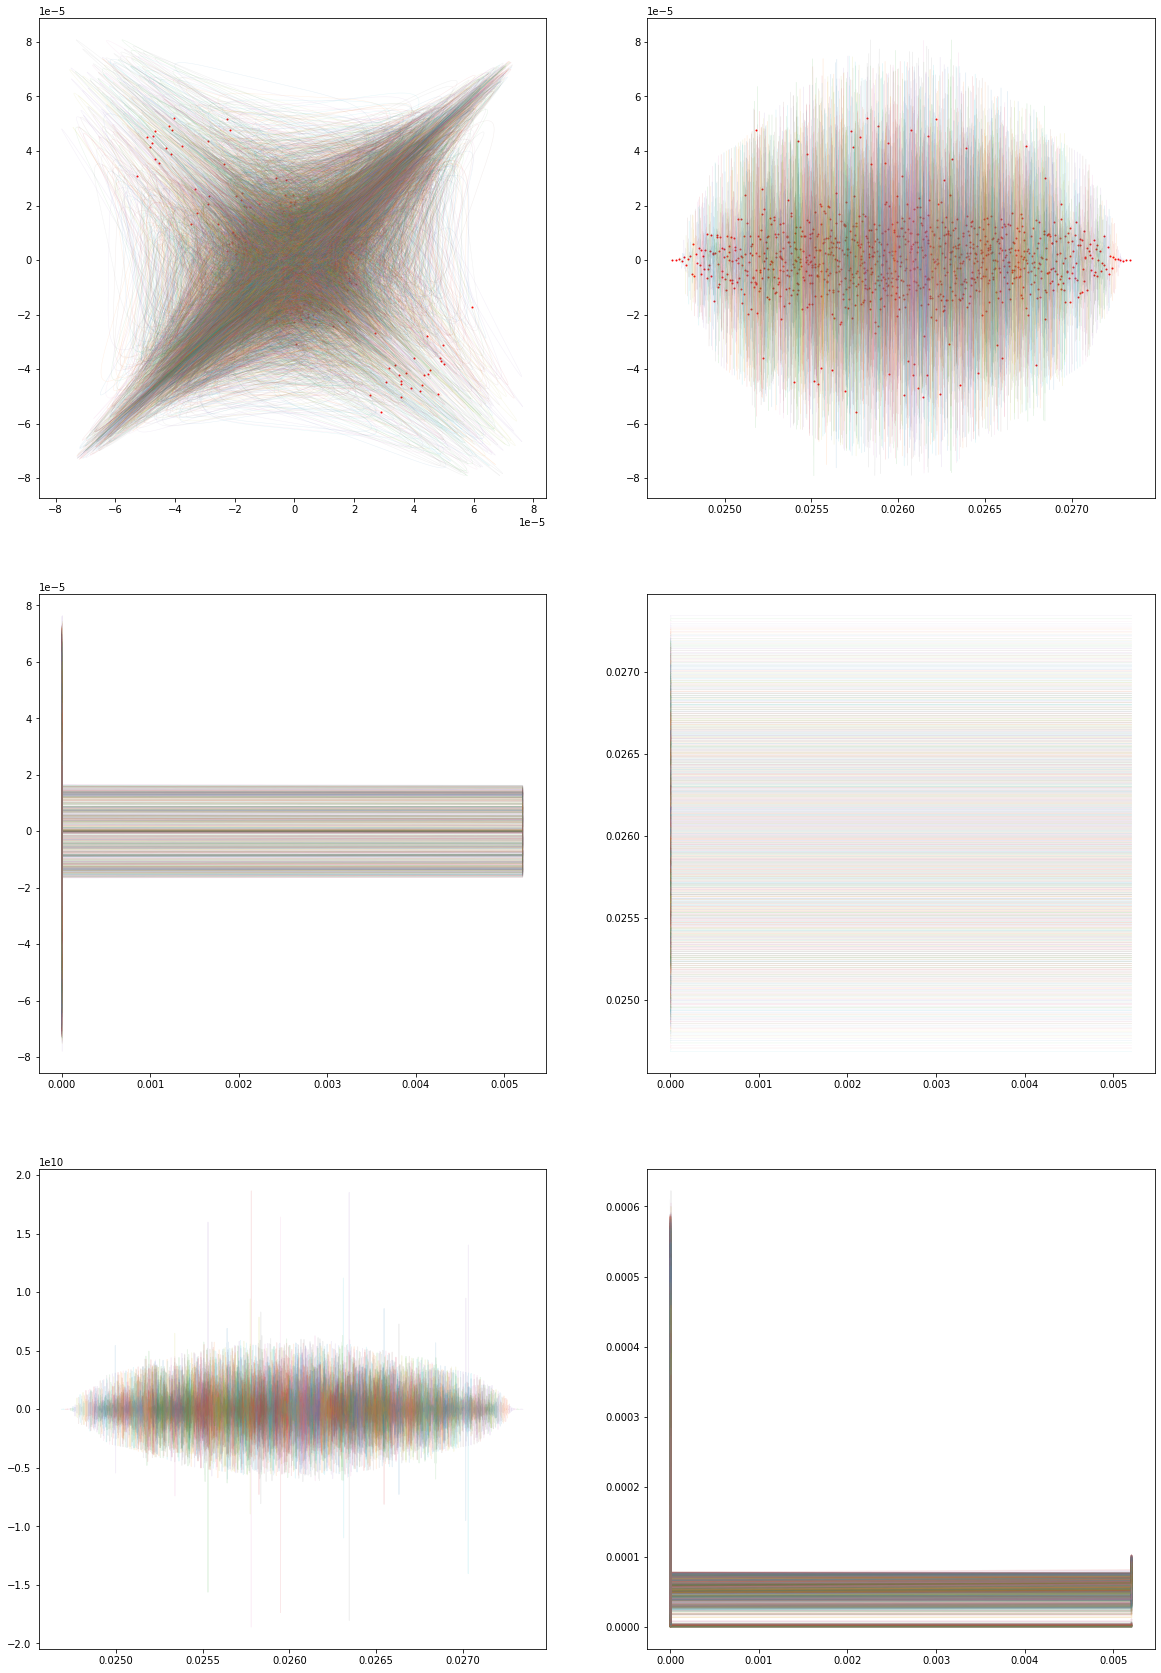

In [ ]:
# %%time
x_axis = trap.axis[0]
y_axis = trap.axis[1]
z_axis = trap.axis[2]

phi3d = trap.get_full_geometry()
phi_xy = phi3d.get_section('z',trap.config['z0'])
phi_yz = phi3d.get_section('x',0)

ions_left_id = trap.ansamble.ion_id.cpu().numpy()
ions_gone = set (trap.ansamble.trajectory.keys()) - set(trap.ansamble.ion_id.cpu().numpy())
# print(ions_left_id)

n1 = 0
n2 = -1
ss = 1

# # count = {}
# fig, ax = plt.subplots(1,2, figsize=(20,10))
# x = trap.ansamble.x.cpu()
# y = trap.ansamble.y.cpu()
# z = trap.ansamble.z.cpu()
# # ax[0].pcolor(x_axis, y_axis, phi_xy)
# # ax[1].pcolor(z_axis, y_axis, phi_yz)
# ax[0].scatter(x,y, c='r', s=40, alpha=0.3)
# ax[1].scatter(z,y, c='r', s=40, alpha=0.3)

scale = 2
fig, ax = plt.subplots(3,2, figsize=(10*scale,15*scale))

# ax[0][0].pcolor(x_axis, y_axis, phi_xy)
# ax[0][1].pcolor(z_axis, y_axis, phi_yz)

trajectory = trap.ansamble.trajectory
# print(trajectory[101])
# for ion_name in trajectory.keys():
# for ion_name in ions_gone:
for ion_name in ions_left_id:
# for ion_name in [55]:
    t = trajectory[ion_name]
    t, x, y, z, vx, vy, vz, acx, acy, acz  = np.array(t).T
    # count[ion_name] = {'lifetime': len(z), 'fin_z': z[-1]}

    ax[0][0].plot(x[n1:n2:ss],y[n1:n2:ss], linewidth=0.5, alpha=0.1)
    ax[0][1].plot(z[n1:n2:ss],y[n1:n2:ss], linewidth=0.5, alpha=0.1)
    ax[1][0].plot(t[n1:n2:ss], x[n1:n2:ss], linewidth=0.5, alpha=0.1)
    ax[1][1].plot(t[n1:n2:ss], z[n1:n2:ss], linewidth=0.5, alpha=0.1)
    ax[2][0].plot(z[n1:n2:ss], acx[n1:n2:ss], linewidth=1, alpha=0.1)
    # ax[2][1].plot(t[n1:n2:ss], ((acx**2+acy**2+acz**2))[n1:n2:ss])
    ax[2][1].plot(t[n1:n2:ss], trap.ansamble.mass/1.6e-19*(np.sqrt(vx**2+vy**2+vz**2)/2)[n1:n2:ss], alpha=0.1)
    if len(x) > n1:
        p = -1
        ax[0][0].scatter(x[p],y[p], c='r', s=1)
        ax[0][1].scatter(z[p],y[p], c='r', s=1)
    # break

# print(count)
# np.sqrt(x)

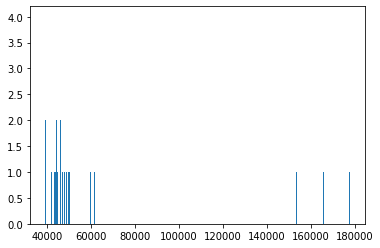

In [ ]:
lifetimes = []

for ion in count:
    l = count[ion]['lifetime']
    if l>n1 and l < 200000:
        if count[ion]['fin_z'] > 80e-3:
            lifetimes.append(count[ion]['lifetime'])

# print(lifetimes)
plt.hist(lifetimes, bins=1000);

In [ ]:
# import dill
# f = open('trah', 'wb')
# dill.dump(trajectory, f)
# f.close()

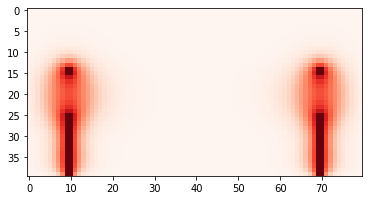

In [ ]:
phi1 = trap.get_full_phi(1e6/4)
# phi2 = trap.ring2.potential
a1 = phi1.get_section('x', 0)
# a2 = phi2.get_section('y', 0)
plt.imshow(a1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


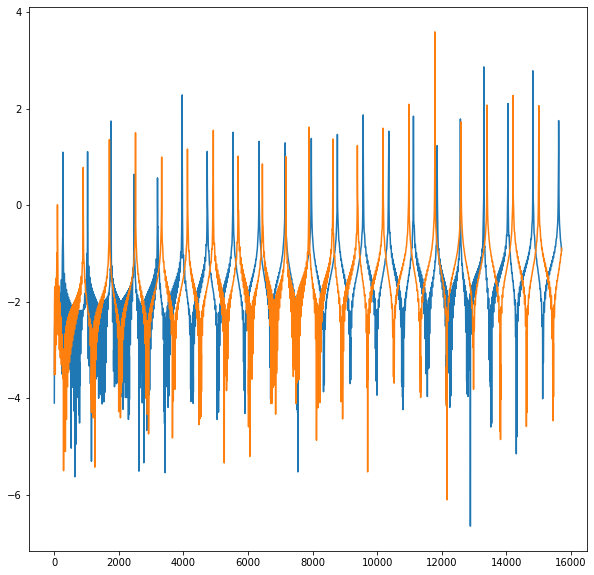

In [ ]:
err = (r5 - r50[::10])/r50[::10]
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.log10(np.abs(err)))

In [ ]:
def run (frame, ax):
    print('FRAME: {}'.format(frame))
    ax.cla()
#     phi_mag = np.abs(field[frame])
#     ax.imshow(phi_mag)
    phi_angle = np.angle(field[frame])
    ax.imshow(phi_angle, cmap=cm.twilight)
    ax.set_title(frame)
    return None

xx, yy = np.meshgrid(x,y)

fig, ax = plt.subplots(figsize=(8,5))

ax.set_frame_on(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


frames = 100
ani = animation.FuncAnimation(fig, run, frames=frames, fargs=[ax], interval=200, repeat=False)
# ani.save('trap_oscillating_3.mp4',fps=60, dpi=200)

In [ ]:
# %%time

# def run (frame, ax, trap):
#     print('FRAME: {}'.format(frame))
#     ax.cla()
#     phi = trap.get_full_phi(frame)
#     p = phi.get_section('z', 0)
#     ax.plot_surface(xx, yy, p, rstride=1, cstride=1, cmap=cm.viridis)
#     ax.set_xlim(np.min(x), np.max(x))
#     ax.set_ylim(np.min(y), np.max(y))
#     ax.set_zlim(-1, 1)
#     ax.view_init(50, 135)
#     ax.set_title(frame)
#     return None

# xx, yy = np.meshgrid(x,y)

# fig = plt.figure()
# ax = Axes3D(fig)
# # fig, ax = plt.subplots(figsize=(8,5)))

# ax.set_frame_on(False)
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
# ax.plot_surface(xx, yy, E.get_section('z', 0), rstride=1, cstride=1, cmap=cm.viridis)



# frames = 300
# ani = animation.FuncAnimation(fig, run, frames=frames, fargs=[ax, trap], interval=200, repeat=False)
# ani.save('trap_oscillating_2.mp4',fps=60, dpi=200)

In [ ]:
f = open('dump_trap', 'wb')
dill.dump(trap, f)
f.close()

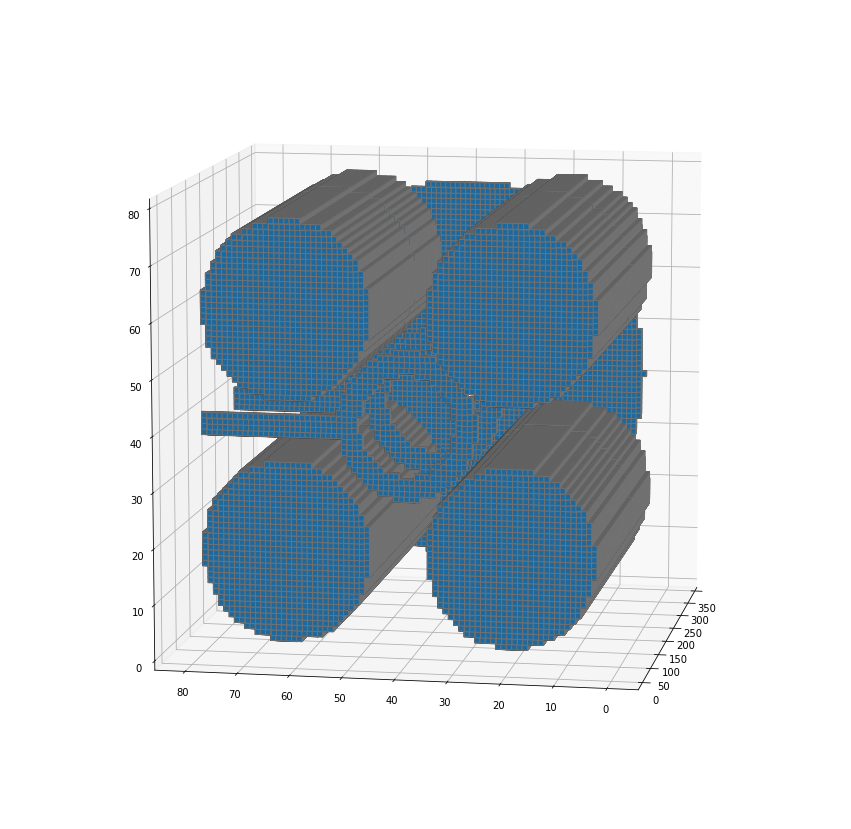

CPU times: user 8min 5s, sys: 3.51 s, total: 8min 9s
Wall time: 8min 8s


In [ ]:
%%time

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

gg = trap.get_full_geometry()
to_plot = gg[:,:,:].transpose()
ax.voxels(to_plot, edgecolors='gray')
ax.view_init(elev=10, azim=190)
plt.show()

In [ ]:
print('{} {} '.format(15,16,17))

15 16 


#Push to GitHub

In [1]:
!git add Trap_simulation_structured.ipynb

fatal: not a git repository (or any of the parent directories): .git


In [2]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git config --global user.email "drev.tf@gmail.com"
!git config --global user.name "drev"
!git commit -m 'fixed dissipation'

In [ ]:
!git push github master

#Benchmark

In [ ]:
N = 500
a = 1

x = np.linspace(0, N-1, N, dtype=np.int)
y = np.linspace(0, N-1, N, dtype=np.int)
z = np.linspace(0, N-1, N, dtype=np.int)

xx, yy, zz = np.meshgrid(x,y,z)

m = xx + yy + zz

x0, y0, z0 = 2.5, 2.5, 2.5

exact = x0 + y0 + z0
print(exact)

mm = Mesh_3d(axis=np.array([x,y,z]))
mm.set_data(m)
bb = mm.get_nearest_point_value(x0,y0,z0)
print('1', bb)
bb = mm.get_nearest_point_value2(x0,y0,z0)
print('2', bb)

7.5
1 7.5
2 7.5


In [ ]:
%%time
for _ in range(1000):
    phi3d.get_nearest_point_value(x0,y0,z0)

print(phi3d.get_nearest_point_value(x0,y0,z0))    

0.9950752157810926
CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 10.7 ms


In [ ]:
%%time
for _ in range(1000):
    phi3d.get_nearest_point_value2(x0,y0,z0)

print(phi3d.get_nearest_point_value2(x0,y0,z0))    

0.9950752157810926
CPU times: user 477 ms, sys: 72.3 ms, total: 550 ms
Wall time: 478 ms


#Testing

In [ ]:
trap.ansamble.N = 998

In [ ]:
print(trap.ansamble.trajectory)

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [], 50: [], 51: [], 52: [], 53: [], 54: [], 55: [], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: [], 66: [], 67: [], 68: [], 69: [], 70: [], 71: [], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 78: [], 79: [], 80: [], 81: [], 82: [], 83: [], 84: [], 85: [], 86: [], 87: [], 88: [], 89: [], 90: [], 91: [], 92: [], 93: [], 94: [], 95: [], 96: [], 97: [], 98: [], 99: [], 100: [], 101: [], 102: [], 103: [], 104: [], 105: [], 106: [], 107: [], 108: [], 109: [], 111: [], 112: [], 113: [], 114: [], 115: [], 116: [], 117: [], 118: [], 119: [], 120: [], 121: [], 122: [], 123: [], 12

In [ ]:
%time
N = 100
trap.ansamble.ion_source(N, 0, 0, 0, 0.01, 0.01, 0.01, 0, 0, 0)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [ ]:
# print(trap.ansamble.ion_id)

In [ ]:
# trap.ansamble.remove_ion(9)
# print(trap.ansamble.ion_id)
# trap.ansamble.add_ion(np.random.rand(3), np.random.rand(3))
# print(trap.ansamble.ion_id)

In [ ]:
%%time

a = trap.ansamble.interaction2()

check took 5.17e-03 sec
CPU times: user 2.27 ms, sys: 19 µs, total: 2.29 ms
Wall time: 6.27 ms


In [ ]:
print(np.random.normal(0,1,10))

[ 0.99688823  1.53474391 -0.08032675  1.07426964  0.99624311  0.64242787
  0.66729817  0.73468391 -0.49647381  0.52868348]


In [ ]:
a = torch.tensor([[1,2],[3,4]], device='cuda')
print(a.cpu().numpy())

[[1 2]
 [3 4]]


In [ ]:
a = torch.zeros(3)
b = torch.zeros(3)

d = torch.stack([a,b])
print(d[0])

tensor([0., 0., 0.])
